In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")

In [26]:
train_file = "train.csv"
test_file = "test.csv"

In [27]:
train_df = pd.read_csv(train_file)
train_df.rename(columns={'target':'label'}, inplace=True)
train_df

,id,keyword,location,text,label
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [28]:
# merge 'keyword' and 'location' columns with 'text' column

train_df = train_df.fillna('')
train_df['text'] = train_df[['keyword', 'location', 'text']].agg(' '.join, axis=1)
train_df = train_df.drop(columns = ['keyword', 'location'])

def length(text):
    return len(text.split())

train_df['num_words'] = train_df.text.apply(length)
train_df

,id,text,label,num_words
0,1,Our Deeds are the Reason of this #earthquake...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' ar...,1,22
3,6,"13,000 people receive #wildfires evacuation ...",1,8
4,7,Just got sent this photo from Ruby #Alaska a...,1,16
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse i...,1,11
7609,10870,@aria_ahrary @TheTawniest The out of control...,1,20
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. h...,1,8
7611,10872,Police investigating after an e-bike collide...,1,19


## Explore the data

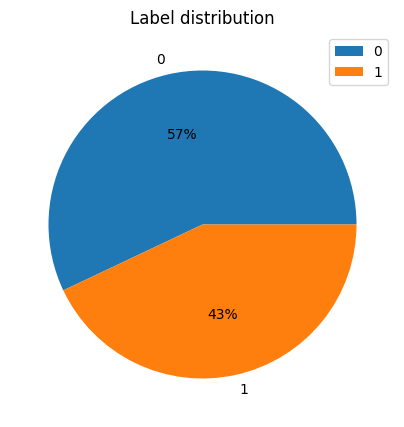

In [29]:
classes = pd.value_counts(train_df["label"])
classes.plot(kind='pie',figsize=(5,5),autopct='%0.f%%', legend=True, title ="Label distribution") 
plt.ylabel('')
plt.show()

The distribution of labels is somewhat balanced, so I will be using the accuracy score as well as f1

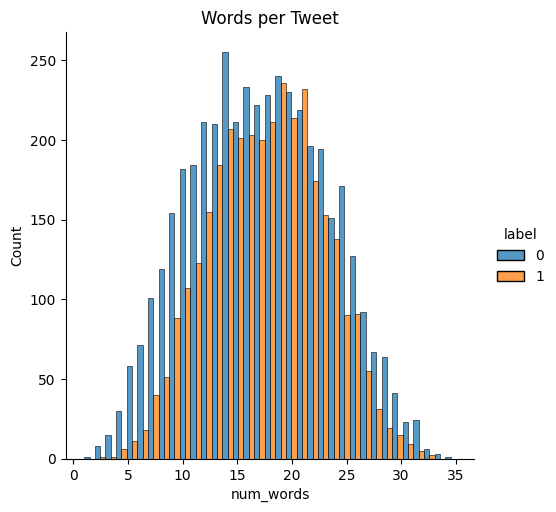

In [6]:
sns.displot(train_df, x=train_df.num_words, hue=train_df.label, bins=train_df.num_words.max(), multiple="dodge")
plt.title('Words per Tweet')
plt.show()

In [129]:
def wordcloud_label(df, label):
    plt.figure(figsize = (10,10)) 
    wc = WordCloud(
        max_words = 1000, 
        width = 1600,
        height = 800, 
        stopwords = STOPWORDS,
        max_font_size = 90,
        min_font_size = 15
    ).generate(" ".join(df[df.label == label].text))
    plt.axis("off")
    plt.imshow(wc, interpolation = 'bilinear')

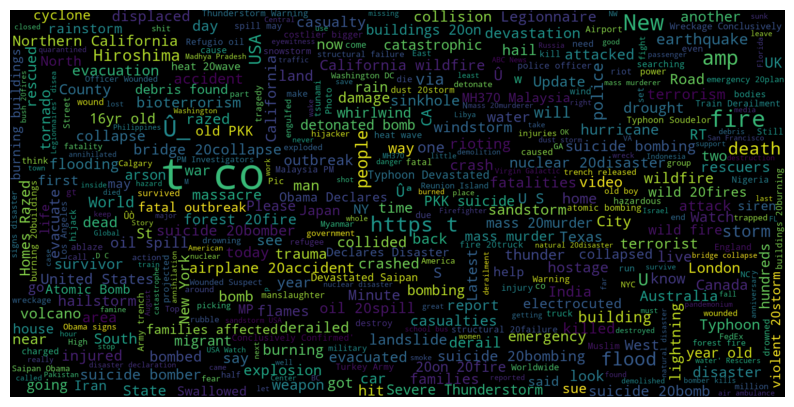

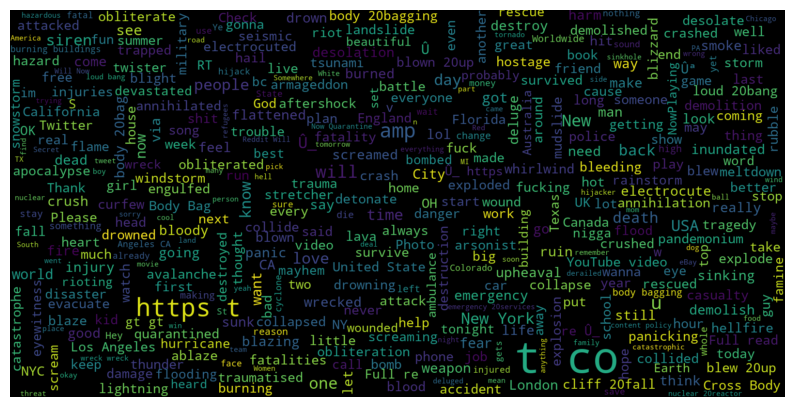

In [130]:
wordcloud_label(train_df, 1)
wordcloud_label(train_df, 0)

## Create preprocessor class and assemble pipeline

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

class RegexClean(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def prep(text):
            text = re.sub(r'https?:\/\/\S+', "", text)
            text = re.sub(r'&amp;', '', text)
            text = re.sub(r'[\/%]', ' ', text)
            text = re.sub(r'@[A-Za-z0-9_]+', "", text)
            text = re.sub(r'\[.*\]', '', text)
            text = re.sub(r'[^A-Za-z\s]*', "", text)
            text = re.sub(r'\s+', " ", text)
            text = text.lower()
            return text
        if isinstance(X, pd.Series):
            return X.apply(prep)
        else:
            raise ValueError("Input should be a pandas Series")
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [31]:
from sklearn.pipeline import Pipeline

def pipeline_template(preprocessor, vectorizer, classifier):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('vectorizer', vectorizer),
    ('classifier', classifier),
    ])
    return model

## Baseline model with GradientBoostingClassifier

In [32]:
# create train/test splits

from sklearn.model_selection import train_test_split

X = train_df['text']
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Base train accuracy: 0.7794745484400657
Base train F1: 0.7689862321560571
Base train ROC-AUC: 0.753532986219035
Base test accuracy: 0.7426132632961261
Base test F1: 0.733573131676359
Base test ROC-AUC: 0.733573131676359


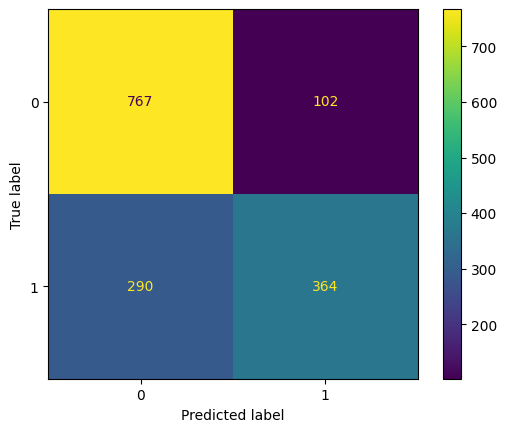

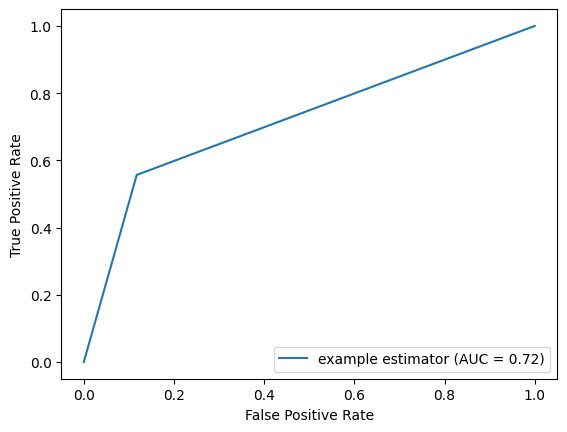

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

preprocessor = RegexClean()
base_vectorizer = TfidfVectorizer()
base_classifier = GradientBoostingClassifier()

model = pipeline_template(preprocessor, base_vectorizer, base_classifier)

model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print('Base train accuracy:', accuracy_score(y_train, train_preds))
print('Base train F1:', f1_score(y_train, train_preds, average='weighted'))
print('Base train ROC-AUC:', roc_auc_score(y_train, train_preds, average='weighted'))
print('Base test accuracy:', accuracy_score(y_test, test_preds))
print('Base test F1:', f1_score(y_test, test_preds, average='weighted'))
print('Base test ROC-AUC:', f1_score(y_test, test_preds, average='weighted'))

cm = confusion_matrix(y_test, test_preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                               estimator_name='example estimator')
display.plot()
plt.show()

# Train various classification models with GridSearchCV

In [51]:
# defining the vectorizer and the parameter grid

vectorizer = TfidfVectorizer()
vect_parameters = {
    'vectorizer__stop_words': [None, 'english'],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__min_df': [3,5,10],
    'vectorizer__max_df': [0.8, 0.9, 0.95]
}

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# defining models and parameters for grid search
# train all models at the risk of a long training time,
# or train only uncommented

classifiers = {
    MultinomialNB(): 'MultinomialNB',
    # SVC(): 'SVC',
    # LogisticRegression(): 'LogisticRegression',
    # DecisionTreeClassifier(): 'DecisionTree',
    # RandomForestClassifier(): 'RandomForest',
    # GradientBoostingClassifier(): 'GradientBoosting'
}

all_clf_parameters = [
    {
        'classifier__alpha': [0.3, 0.4, 0.5, 0.6]
    },
    # {
    #     'classifier__C': [1.0,10.0,100.0,500.0], 
    #     'classifier__gamma': [1,0.1,0.001,0.0001], 
    #     'classifier__kernel': ['linear','rbf']
    # },
    # {
    #     'classifier__C': [0.1, 1, 3, 5], 
    #     'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
    #     'classifier__max_iter': [100, 200, 300]
    # },
    # {
    #     'classifier__criterion': ['gini','entropy'],
    #     'classifier__max_depth':[5, 30, 50]
    # },
    # {
        # 'classifier__n_estimators': [300,500,700],
        # 'classifier__max_depth': [20,40,50],
    #     'classifier__min_samples_split': [2,4,10,20],
    #     'classifier__min_samples_leaf': [1,2,3,5,7]
    # },
    # {
    #     'classifier__learning_rate': [0.01, 0.1, 0.3],
    #     'classifier__subsample': [0.9, 0.5, 0.2],
    #     'classifier__n_estimators': [100,500,1000],
    #     'classifier__max_depth': [4,6,8]
    # }
]

0it [00:00, ?it/s]

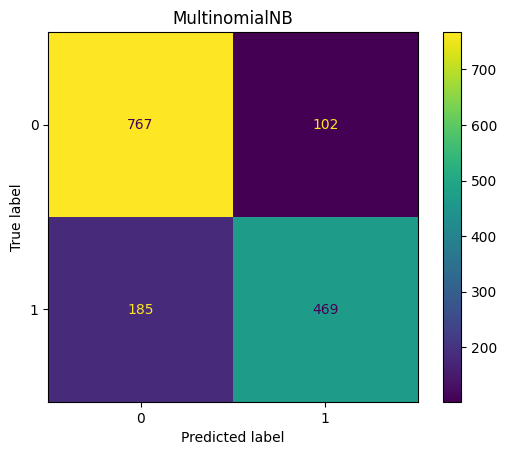

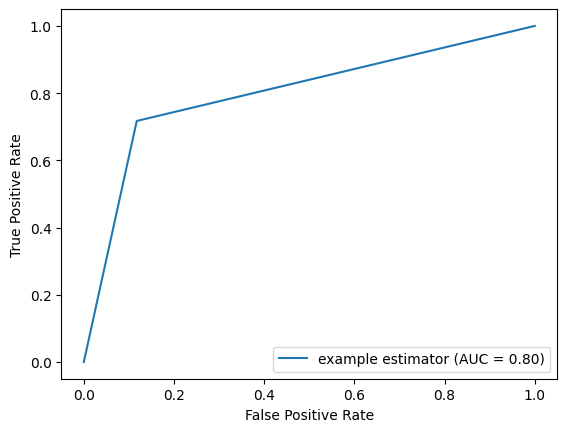

1it [00:36, 36.91s/it]


,MultinomialNB
train_accuracy,0.855008
test_accuracy,0.811556
train_f1,0.852964
test_f1,0.809467
best_params,"{'classifier__alpha': 0.5, 'vectorizer__max_df..."


In [56]:
index = ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'best_params']
best_results_df = pd.DataFrame(index=index)

for clf, clf_parameters in tqdm(zip(classifiers.keys(), all_clf_parameters)):
    model = pipeline_template(RegexClean(), vectorizer, clf)
    param_grid = {**vect_parameters, **clf_parameters}
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    train_f1 = f1_score(y_train, train_preds, average='weighted')
    test_f1 = f1_score(y_test, test_preds, average='weighted')

    best_results_df[classifiers[clf]] = [train_accuracy, test_accuracy, train_f1, test_f1, best_params]

    cm = confusion_matrix(y_test, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{classifiers[clf]}')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, test_preds)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                               estimator_name='example estimator')
    display.plot()
    plt.show()

best_results_df

In [57]:
best_results_df.MultinomialNB.loc['best_params']

{'classifier__alpha': 0.5,
 'vectorizer__max_df': 0.8,
 'vectorizer__min_df': 3,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': None}

In [141]:
best_model = pipeline_template(RegexClean(), TfidfVectorizer(), MultinomialNB())
best_params = best_results_df['MultinomialNB'].loc['best_params']
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', RegexClean()),
                ('vectorizer', TfidfVectorizer(max_df=0.8, min_df=3)),
                ('classifier', MultinomialNB(alpha=0.5))])

# Creating predictions with the best model

In [142]:
test_df = pd.read_csv(test_file)
target = [best_model.predict(test_df['text'])]
target_tp = np.transpose(target)

In [143]:
sample_df = pd.read_csv("sample_submission.csv", index_col = 'id')
sample_df['target'] = target_tp
sample_df.to_csv('submission.csv')

In [15]:
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [21]:
print(test_vectors.shape)
print(train_vectors.shape)

(1523, 20190)
(6090, 20190)
